In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from datetime import datetime
import warnings
from ipywidgets import widgets, interactive_output
from IPython.display import display

warnings.filterwarnings("ignore")

In [67]:
df_expuestos = pd.read_csv("data/BD_Expuestos.csv", delimiter="\t", parse_dates=["FECHA_INICIO", "FECHA_CANCELACION", "FECHA_FIN"])

df_sociodem = pd.read_csv("data/BD_Sociodemograficas.csv", encoding="latin-1", delimiter="\t", parse_dates=["FechaNacimiento"])

df_sin = pd.read_csv("data/DB_Siniestros.csv", parse_dates=["Mes_Pago"], date_format="%Y%m")

caps = pd.read_excel("data/listas_de_causas.xlsx")

## Expuestos

In [68]:
# Cambiar los valores con una fecha fin anterior a la fecha de cancelacion
df_expuestos.loc[(df_expuestos["FECHA_CANCELACION"] > df_expuestos["FECHA_FIN"]), "FECHA_FIN"] = df_expuestos.loc[(df_expuestos["FECHA_CANCELACION"] > df_expuestos["FECHA_FIN"]), "FECHA_CANCELACION"] 

# Eliminar columna de fecha de cancelacion
df_expuestos.drop("FECHA_CANCELACION", axis=1, inplace=True)

## Siniestros

In [69]:
df_sin["Diagnostico_Codigo"] = df_sin["Diagnostico_Codigo"].str[0].replace(["W", "X"], ["Y"]*2) + df_sin["Diagnostico_Codigo"].str[1:]

tipo_cap = []

for i in df_sin["Diagnostico_Codigo"]:
    
    if i.isnumeric() or i == "-1":
        tipo_cap.append("Sin Diagnostico")
    else:
        
        for j in range(caps.shape[0]):
            if i[0] == caps.loc[j, "Codigos"][0] or i[0] == caps.loc[j, "Codigos"][4]:
                if int(i[1:3]) in range(int(caps.loc[j, "Codigos"][1:3]), int(caps.loc[j, "Codigos"][-2:])+1):
                    tipo_cap.append(caps.loc[j, "Cap"])
                    break
                else:
                    if i[0] == "H" or i[0] == "D":
                        continue
                    else:
                        tipo_cap.append("Sin info")

df_sin["Cap_CIE"] = tipo_cap  

In [5]:
df_sin.select_dtypes("object").apply(pd.Series.nunique).to_frame().rename({0:"Cantidad de categorias"}, axis=1).T

,Reclamacion,Diagnostico_Codigo,Diagnostico_Desc,Cap_CIE
Cantidad de categorias,41,5808,5751,23


In [70]:
df_sin.drop(["Diagnostico_Desc", "Diagnostico_Codigo", "Reclamacion"], axis=1, inplace=True)

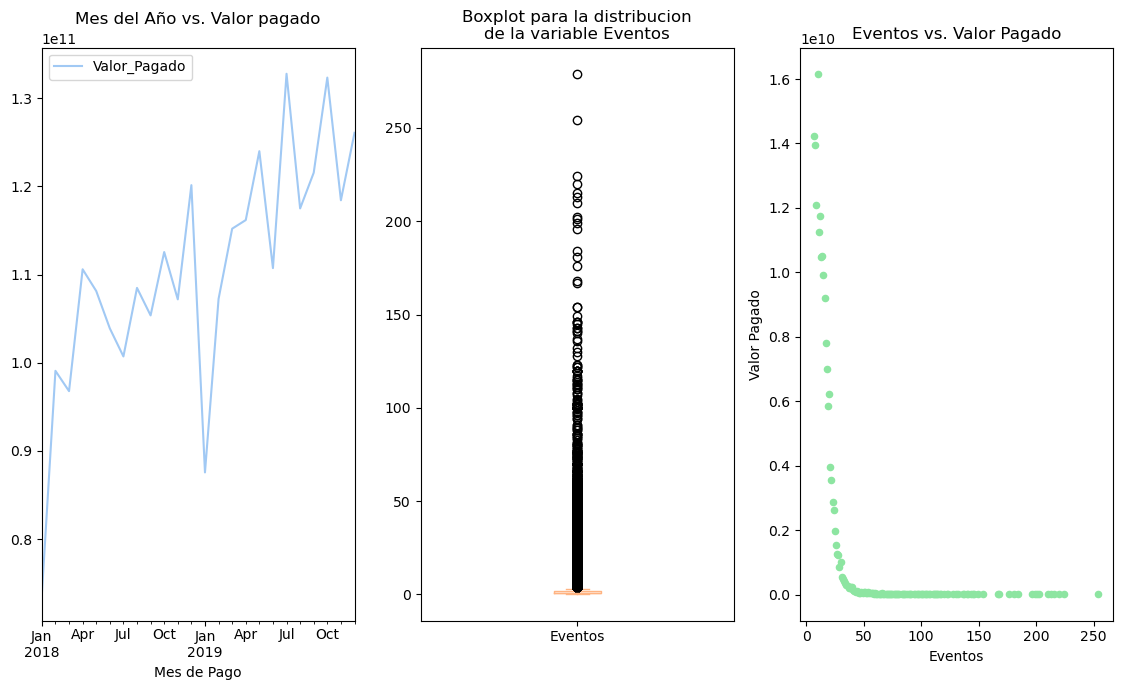

In [7]:
fig = plt.figure(figsize=(7*((1+np.sqrt(5))/2), 7))

ax = plt.subplot(1, 3, 1)

data = df_sin.set_index("Mes_Pago").resample("M")["Valor_Pagado"].sum().to_frame()

df_sin.set_index("Mes_Pago").resample("M")["Valor_Pagado"].sum().to_frame().plot(kind="line", ax=ax, color=sns.color_palette("pastel")[0],
                                                                                title="Mes del Año vs. Valor pagado")
plt.xlabel("Mes de Pago")

ax = plt.subplot(1, 3, 2)

data = df_sin.set_index("Mes_Pago").resample("M")["Valor_Pagado"].sum().to_frame()

df_sin["Eventos"].plot(kind="box", ax=ax, color=sns.color_palette("pastel")[1], title="Boxplot para la distribucion\nde la variable Eventos")

ax = plt.subplot(1, 3, 3)

data = df_sin.set_index("Mes_Pago").resample("M")["Valor_Pagado"].sum().to_frame()

df_sin.groupby("Eventos", as_index=False)["Valor_Pagado"].sum().iloc[7:-1].plot(kind="scatter", x="Eventos", y="Valor_Pagado", ax=ax, color=sns.color_palette("pastel")[2], 
                                                                               title="Eventos vs. Valor Pagado")

plt.ylabel("Valor Pagado")

plt.tight_layout()

plt.show()


In [ ]:
df_sin.sort_values(by=["Cap_CIE", "Eventos"])

In [38]:
wid_1 = widgets.Dropdown(options=np.sort(df_sin["Cap_CIE"].unique()), value="Sin Diagnostico")

def box_graphs(cod):

    df_sin.groupby("Cap_CIE").get_group(cod)["Eventos"].plot(kind="box");
    
output = interactive_output(box_graphs, {"cod":wid_1})
display(wid_1, output)

Dropdown(index=5, options=('I', 'II', 'III', 'IV', 'IX', 'Sin Diagnostico', 'Sin info', 'V', 'VI', 'VII', 'VII…

Output()

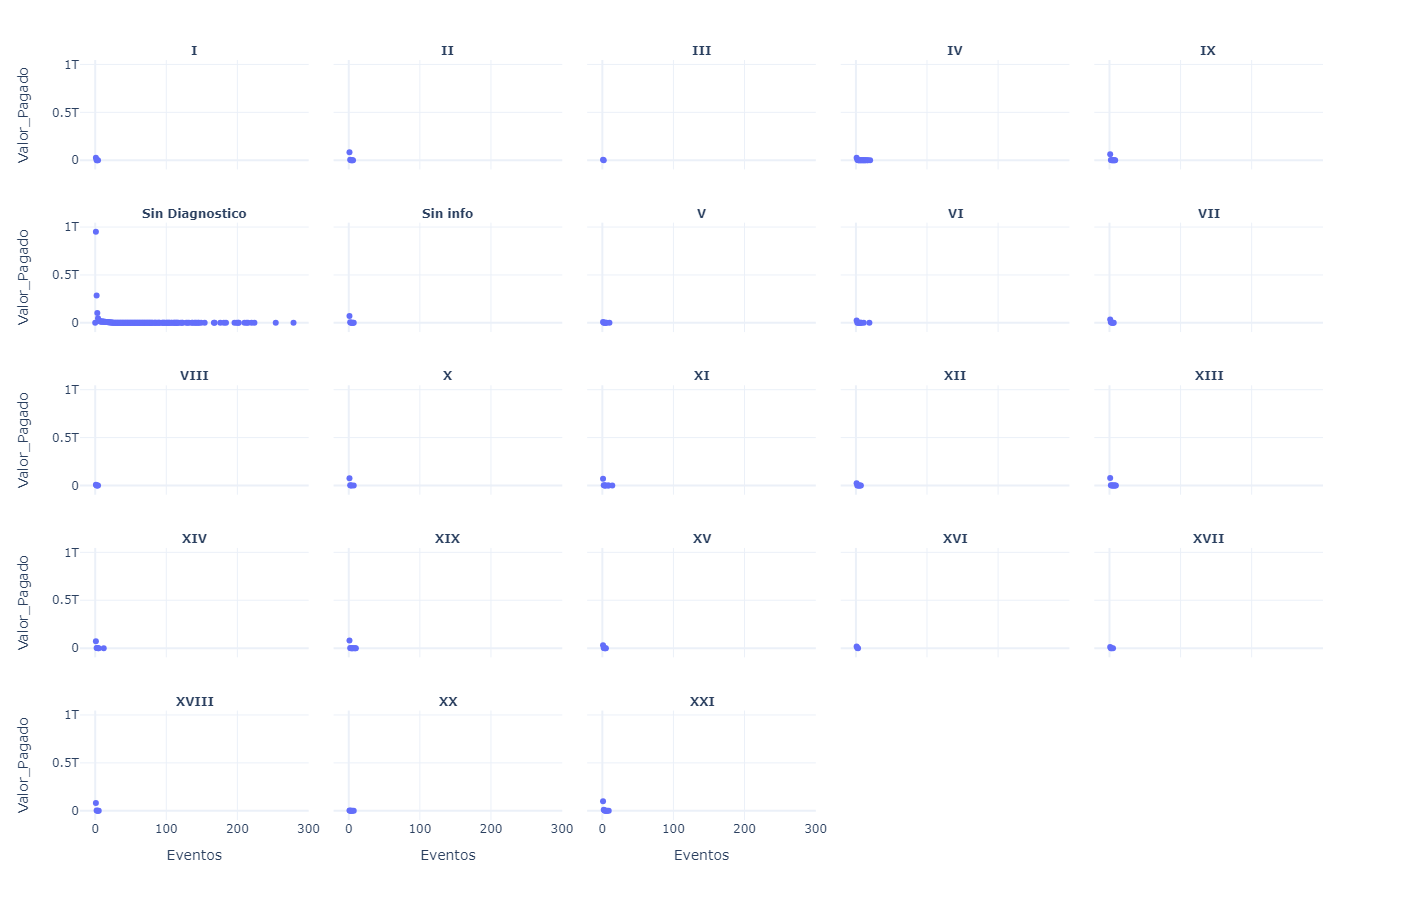

In [34]:
data = df_sin.groupby(["Cap_CIE", "Eventos"], as_index=False)["Valor_Pagado"].sum()

fig = px.scatter(data, x="Eventos", y="Valor_Pagado", facet_col="Cap_CIE", facet_col_wrap=5, width=900*((1+np.sqrt(5))/2), height=900, template="plotly_white")

fig.for_each_annotation(lambda x: x.update(text= f"<b>{x.text.split('=')[1]}</b>"))


In [ ]:
w_1 = widgets.Dropdown(options=np.sort(df_sin["Diagnostico_Codigo"].unique()))

def groupby(w_1):

  df = df_sin[["Reclamacion", "Diagnostico_Codigo", "Diagnostico_Desc"]].groupby("Diagnostico_Codigo").get_group(w_1)
  display(df)

output = interactive_output(groupby, {"w_1":w_1})

display(output, w_1)

## Sociodemo



In [71]:
#Cálculo de la edad a partir de la fecha de nacimiento
df_sociodem["Edad"] = ((datetime.today() - df_sociodem["FechaNacimiento"])/pd.Timedelta(days=365.25)).astype(int)

In [ ]:
# Agrupar el DataFrame df_sociodem por "Ciudad" y "Edad", y sumar los valores de las columnas de enfermedades
data = df_sociodem.groupby(["Ciudad", "Edad"], as_index=False)[["CANCER", "EPOC", "DIABETES", "DIABETES", "ENF_CARDIOVASCULAR"]].sum()

# Convertir el DataFrame en formato largo para facilitar la visualización con Plotly
data = data.melt(id_vars=["Ciudad", "Edad"], value_vars=["CANCER", "EPOC", "DIABETES", "DIABETES", "ENF_CARDIOVASCULAR"], value_name="Total", var_name="Tipo")

# Crear una gráfica de líneas utilizando Plotly Express
fig = px.line(data, x="Edad", y="Total", facet_col="Ciudad", color="Tipo", template="plotly_white", facet_col_wrap=3, 
              labels={"Tipo":"<b>Tipo de enfermedad</b>"}, range_x=0, title="<b>Cantidad de enfermedades por edad,<br>en las distintas ciudades", 
              width=650*((1+np.sqrt(5))/2), height=650, color_discrete_sequence=px.colors.qualitative.T10)

# Actualizar el layout del título para centrarlo
fig.update_layout(title={"x":0.5})

# Modificar las anotaciones para resaltar el nombre de la ciudad
fig.for_each_annotation(lambda x: x.update(text= f"<b>{x.text.split('=')[1]}</b>"))

# Mostrar la gráfica
fig.show()

In [ ]:
df_sociodem["Ciudad"] = df_sociodem["Ciudad"].replace("Sin Información", np.nan)

data = df_sociodem["Ciudad"].value_counts().to_frame().reset_index()

plt.pie(data["count"], labels=data["Ciudad"], autopct="%1.1f%%", colors=sns.color_palette("hls", 9))

plt.title("Porcentaje de datos por Ciudad")

plt.show()

## Cruce de datos

In [78]:
df = df_sin.set_index("Asegurado_Id").join(df_sociodem.set_index("Asegurado_Id"), how="inner").join(df_expuestos.set_index("Asegurado_Id"), how="inner").reset_index()

df.dropna(inplace=True)

In [84]:
df["Asegurado_Id"].nunique()

235444

In [85]:
wid_1 = widgets.Dropdown(options=df["Asegurado_Id"].unique()[:1000])

def groupby(id):
    data = df.groupby("Asegurado_Id").get_group(id)
    display(data)

output = interactive_output(groupby, {"id":wid_1})
display(wid_1, output)

Dropdown(options=(738284, 738288, 738294, 738303, 738318, 738328, 738341, 738347, 738348, 738349, 738358, 7383…

Output()

In [88]:
import sys

sys.executable


'C:\\Users\\Lukas\\anaconda3\\envs\\HR\\python.exe'